In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.api import OLS
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates


In [57]:
TAE_df = pd.read_excel('TAEE11.xlsx', sheet_name= "normal")
TAE_df['Data'] = pd.to_datetime(TAE_df['Data'])
TAE_df['TAE_diff'] = TAE_df['TAE'].diff()
TAE_df = TAE_df.dropna()
TAE_df

,Data,TAE,LN_TAE,LN_DIFF_TAE,TAE_diff
1,2011-02-22,2.155927,0.768221,0.003523,0.007583
2,2011-03-30,2.425554,0.886060,0.117839,0.269627
3,2011-04-29,3.281391,1.188268,0.302208,0.855837
4,2011-05-31,3.281391,1.188268,0.000000,0.000000
5,2011-06-30,3.117224,1.136943,-0.051325,-0.164167
...,...,...,...,...,...
154,2023-11-30,35.831154,3.578818,0.092550,3.167331
155,2023-12-28,37.717987,3.630137,0.051319,1.886834
156,2024-01-31,36.890000,3.607941,-0.022197,-0.827987
157,2024-02-29,35.400000,3.566712,-0.041229,-1.490000


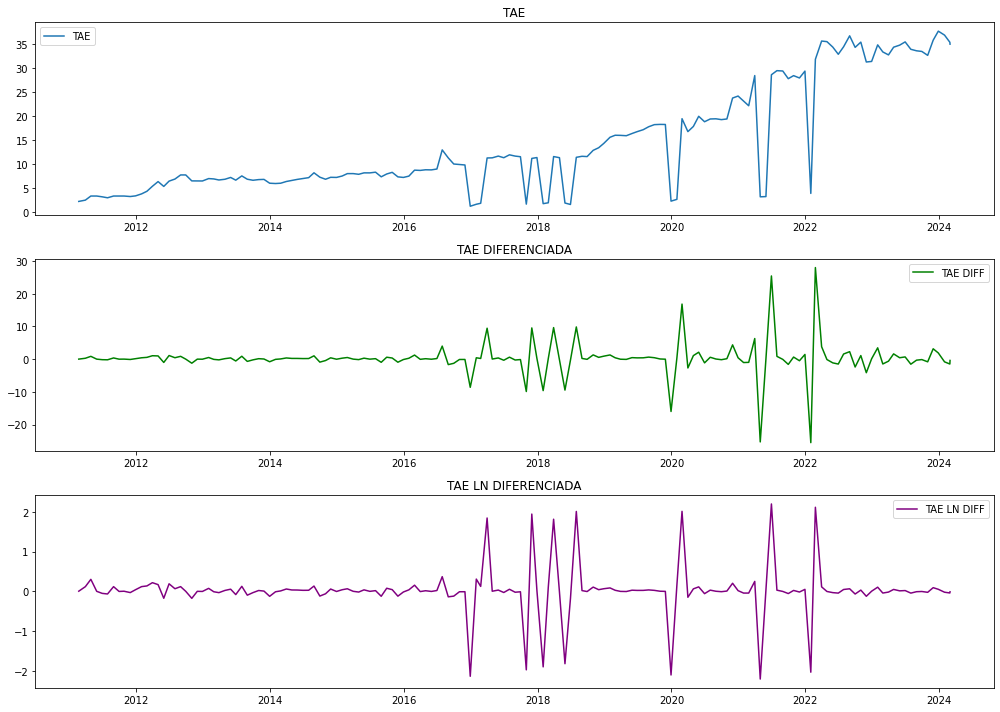

In [58]:
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(TAE_df['Data'] , TAE_df['TAE'], label='TAE')
plt.title('TAE')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(TAE_df['Data'] ,TAE_df['TAE_diff'], label='TAE DIFF', color='green')
plt.title('TAE DIFERENCIADA')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(TAE_df['Data'] ,TAE_df['LN_DIFF_TAE'], label='TAE LN DIFF', color='purple')
plt.title('TAE LN DIFERENCIADA')
plt.legend()

plt.tight_layout()
plt.show()

De cara é perceptível um padrão exponencial ou multiplicativo na série original, vamo testar a estacionariedade

In [59]:
# Function to perform the ADF test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# Apply the ADF test on each series
print("TAE:")
adf_test(TAE_df['TAE'])

print("\nTAE DIFF:")
adf_test(TAE_df['TAE_diff'])

print("\nTAE LN:")
adf_test(TAE_df['LN_TAE'])

print("\nTAE LN DIFF:")
adf_test(TAE_df['LN_DIFF_TAE'])

TAE:
Results of Dickey-Fuller Test:
Test Statistic                   0.556738
p-value                          0.986499
#Lags Used                       7.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64

TAE DIFF:
Results of Dickey-Fuller Test:
Test Statistic                -9.478702e+00
p-value                        3.925598e-16
#Lags Used                     6.000000e+00
Number of Observations Used    1.510000e+02
Critical Value (1%)           -3.474416e+00
Critical Value (5%)           -2.880878e+00
Critical Value (10%)          -2.577081e+00
dtype: float64

TAE LN:
Results of Dickey-Fuller Test:
Test Statistic                  -1.390039
p-value                          0.587042
#Lags Used                       7.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.88100

Ela é estacionária diferenciada e ln diferenciada.

In [60]:
#estatisticas descritivas
print(TAE_df.info())
print(TAE_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 1 to 158
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data         158 non-null    datetime64[ns]
 1   TAE          158 non-null    float64       
 2   LN_TAE       158 non-null    float64       
 3   LN_DIFF_TAE  158 non-null    float64       
 4   TAE_diff     158 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.4 KB
None
              TAE      LN_TAE  LN_DIFF_TAE    TAE_diff
count  158.000000  158.000000   158.000000  158.000000
mean    14.363582    2.334382     0.017662    0.207922
std     11.067891    0.865609     0.607729    5.172311
min      1.148327    0.138306    -2.210221  -25.546209
25%      6.606192    1.888005    -0.021765   -0.230420
50%      9.816279    2.284030     0.011478    0.124519
75%     19.428889    2.966761     0.058658    0.543354
max     37.717987    3.630137     2.201836   28.0

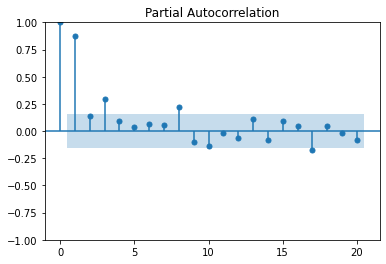

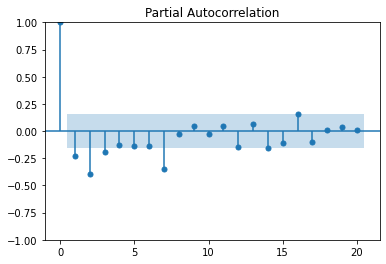

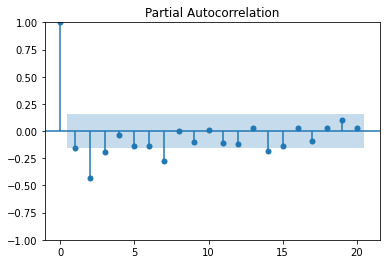

In [6]:
ploct =plot_pacf(TAE_df['TAE'], lags=20, alpha=0.05)
ploct2 =plot_pacf(TAE_df['TAE_diff'], lags=20, alpha=0.05)
ploct3 =plot_pacf(TAE_df['LN_DIFF_TAE'], lags=20, alpha=0.05)

In [63]:
indicadores = pd.read_excel('indicadores.xlsx', sheet_name= "normal")
indicadores['Data'] = pd.to_datetime(indicadores['Data'])
indicadores
indicadores['CAMBIO_diff'] = indicadores['CAMBIO'].diff()
indicadores['IBC-BR_diff'] = indicadores['IBC-BR'].diff()

#criando um dataframe com as variáveis que serão utilizadas
new_df = indicadores.loc[:, ['Data','IPCA', 'CAMBIO_diff', 'IBC-BR_diff', 'SELIC', 'IGP-M', 'DUMMY']]
new_df = new_df.dropna()
#new_df

#juntando um new_df com o  CCR_df
df = pd.merge(TAE_df, new_df, on='Data')
df

,Data,TAE,LN_TAE,LN_DIFF_TAE,TAE_diff,IPCA,CAMBIO_diff,IBC-BR_diff,SELIC,IGP-M,DUMMY
0,2011-04-29,3.281391,1.188268,0.302208,0.855837,0.77,-0.07,-5.04,0.840161,0.45,0
1,2011-05-31,3.281391,1.188268,0.000000,0.000000,0.47,0.02,3.34,0.987988,0.43,0
2,2011-06-30,3.117224,1.136943,-0.051325,-0.164167,0.15,-0.02,-1.48,0.956276,-0.18,0
3,2011-07-29,2.915920,1.070185,-0.066758,-0.201304,0.16,-0.03,3.44,0.967883,-0.12,0
4,2011-08-31,3.281391,1.188268,0.118082,0.365471,0.37,0.04,2.32,1.074062,0.44,0
...,...,...,...,...,...,...,...,...,...,...,...
149,2023-10-31,32.663823,3.486268,-0.024728,-0.817775,0.24,0.12,0.17,0.997572,0.50,0
150,2023-11-30,35.831154,3.578818,0.092550,3.167331,0.28,-0.16,-0.74,0.915991,0.59,0
151,2023-12-28,37.717987,3.630137,0.051319,1.886834,0.56,0.00,-0.23,0.894529,0.74,0
152,2024-01-31,36.890000,3.607941,-0.022197,-0.827987,0.42,0.01,-3.59,0.966696,0.07,0


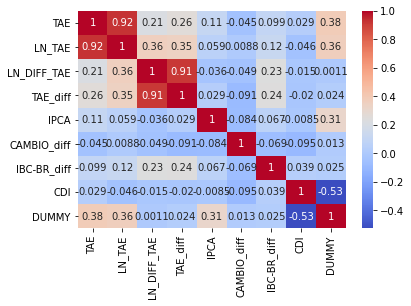

In [62]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [104]:
corr_matrix

,TAE,LN_TAE,LN_DIFF_TAE,TAE_diff,IPCA,CAMBIO_diff,IBC-BR_diff,CDI,DUMMY
TAE,1.000000,0.923046,0.213327,0.256063,0.105783,-0.045103,0.098999,0.028623,0.383457
LN_TAE,0.923046,1.000000,0.358684,0.348898,0.058505,0.008823,0.121718,-0.045714,0.363859
LN_DIFF_TAE,0.213327,0.358684,1.000000,0.910544,-0.036056,-0.049348,0.232639,-0.014737,0.001076
TAE_diff,0.256063,0.348898,0.910544,1.000000,0.029121,-0.091350,0.239504,-0.020411,0.024054
IPCA,0.105783,0.058505,-0.036056,0.029121,1.000000,-0.084397,0.066662,-0.008537,0.311422
CAMBIO_diff,-0.045103,0.008823,-0.049348,-0.091350,-0.084397,1.000000,-0.069342,-0.095369,0.013294
IBC-BR_diff,0.098999,0.121718,0.232639,0.239504,0.066662,-0.069342,1.000000,0.038500,0.024585
CDI,0.028623,-0.045714,-0.014737,-0.020411,-0.008537,-0.095369,0.038500,1.000000,-0.526834
DUMMY,0.383457,0.363859,0.001076,0.024054,0.311422,0.013294,0.024585,-0.526834,1.000000


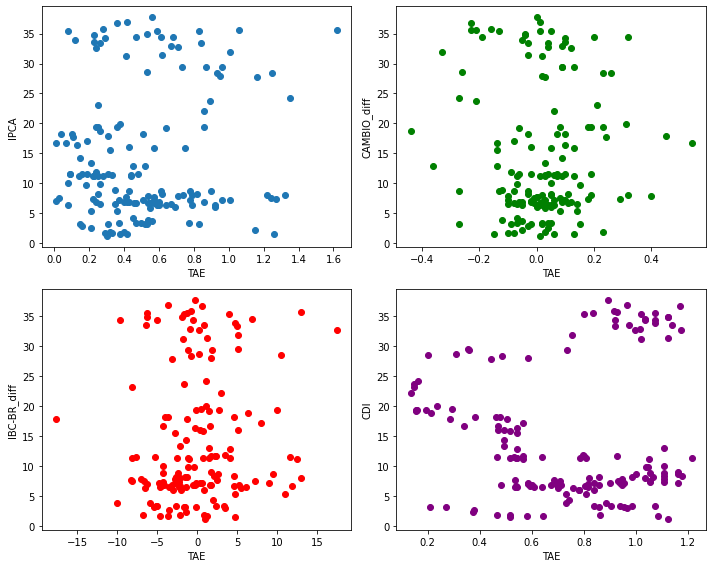

In [10]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Scatter plot 1
axes[0, 0].scatter( df['IPCA'], df['TAE'])
axes[0, 0].set_xlabel('TAE')
axes[0, 0].set_ylabel('IPCA')

# Scatter plot 2
axes[0, 1].scatter( df['CAMBIO_diff'], df['TAE'], color='green')
axes[0, 1].set_xlabel('TAE')
axes[0, 1].set_ylabel('CAMBIO_diff')

# Scatter plot 3
axes[1, 0].scatter(df['IBC-BR_diff'] , df['TAE'], color='red')
axes[1, 0].set_xlabel('TAE')
axes[1, 0].set_ylabel('IBC-BR_diff')

# Scatter plot 4
axes[1, 1].scatter( df['CDI'], df['TAE'], color='purple')
axes[1, 1].set_xlabel('TAE')
axes[1, 1].set_ylabel('CDI')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

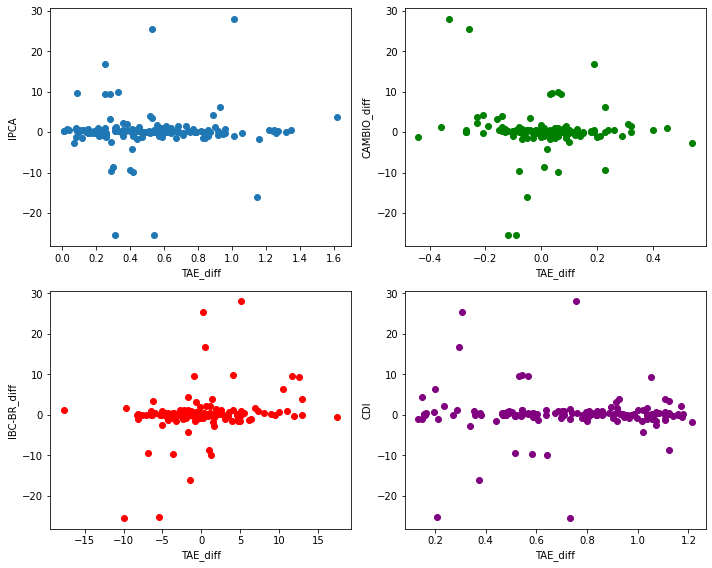

In [11]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Scatter plot 1
axes[0, 0].scatter( df['IPCA'], df['TAE_diff'])
axes[0, 0].set_xlabel('TAE_diff')
axes[0, 0].set_ylabel('IPCA')

# Scatter plot 2
axes[0, 1].scatter( df['CAMBIO_diff'], df['TAE_diff'], color='green')
axes[0, 1].set_xlabel('TAE_diff')
axes[0, 1].set_ylabel('CAMBIO_diff')

# Scatter plot 3
axes[1, 0].scatter(df['IBC-BR_diff'] , df['TAE_diff'], color='red')
axes[1, 0].set_xlabel('TAE_diff')
axes[1, 0].set_ylabel('IBC-BR_diff')

# Scatter plot 4
axes[1, 1].scatter( df['CDI'], df['TAE_diff'], color='purple')
axes[1, 1].set_xlabel('TAE_diff')
axes[1, 1].set_ylabel('CDI')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

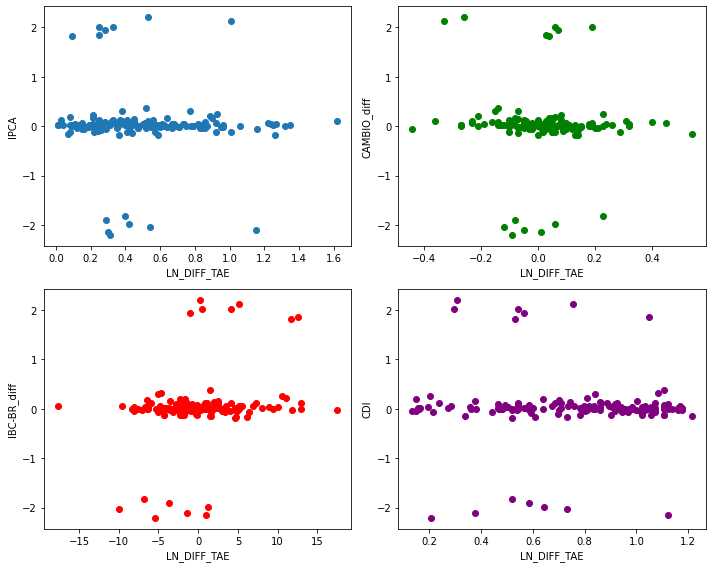

In [12]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Scatter plot 1
axes[0, 0].scatter( df['IPCA'], df['LN_DIFF_TAE'])
axes[0, 0].set_xlabel('LN_DIFF_TAE')
axes[0, 0].set_ylabel('IPCA')

# Scatter plot 2
axes[0, 1].scatter( df['CAMBIO_diff'], df['LN_DIFF_TAE'], color='green')
axes[0, 1].set_xlabel('LN_DIFF_TAE')
axes[0, 1].set_ylabel('CAMBIO_diff')

# Scatter plot 3
axes[1, 0].scatter(df['IBC-BR_diff'] , df['LN_DIFF_TAE'], color='red')
axes[1, 0].set_xlabel('LN_DIFF_TAE')
axes[1, 0].set_ylabel('IBC-BR_diff')

# Scatter plot 4
axes[1, 1].scatter( df['CDI'], df['LN_DIFF_TAE'], color='purple')
axes[1, 1].set_xlabel('LN_DIFF_TAE')
axes[1, 1].set_ylabel('CDI')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

ela pura não apresenta uma relação linear mas ela estacionariezada de ambas as formas apresenta porém com alguns outliers. definir se tratamento é ideal.
Vou continuar a análise, rodar o modelo sem o tratamento de outlier e apos isso rodar o modelo com o tratamento de outlier.
Na série da CCR o tratamento não foi eficaz pois o com o z-score não se mostrou eficiente e o com o quartil revelou que a relação das variáveis não parecia ser linear.

Holtwinters fez o terror, entendi nada.

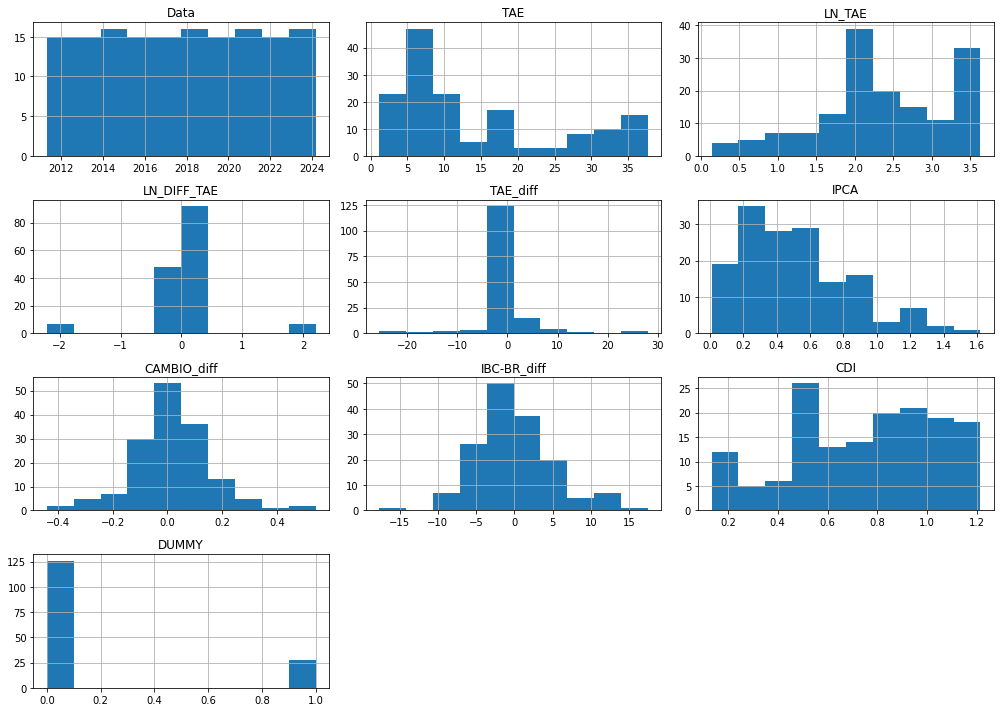

In [13]:
df.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

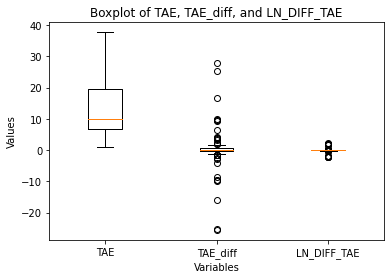

In [14]:
import matplotlib.pyplot as plt

# Create a list of the variables you want to plot
variables = ['TAE', 'TAE_diff', 'LN_DIFF_TAE']

# Create a list of the corresponding data for each variable
data = [df['TAE'], df['TAE_diff'], df['LN_DIFF_TAE']]

# Create the boxplot
plt.boxplot(data, labels=variables)

# Add a title and labels to the plot
plt.title('Boxplot of TAE, TAE_diff, and LN_DIFF_TAE')
plt.xlabel('Variables')
plt.ylabel('Values')

# Show the plot
plt.show()

In [65]:
import statsmodels.api as sm

# Define the independent variables
X = df[[ 'IPCA', 'CAMBIO_diff','SELIC', 'IGP-M', 'DUMMY', 'IBC-BR_diff']]
# Add a constant column to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df['TAE_diff']

# Fit the multiple regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               TAE_diff   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.056
Date:                Mon, 10 Jun 2024   Prob (F-statistic):             0.0619
Time:                        15:09:07   Log-Likelihood:                -466.86
No. Observations:                 154   AIC:                             947.7
Df Residuals:                     147   BIC:                             969.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4211      1.582      0.899      

In [49]:
def backward_stepwise_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    while len(initial_features) > 0:
        model = sm.OLS(y, X[initial_features]).fit()
        p_values = model.pvalues.iloc[1:]  # Ignorar a constante
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            initial_features.remove(excluded_feature)
            print(f'Removed feature: {excluded_feature}, p-value: {max_p_value}')
        else:
            break
    return model

In [66]:
# Define the independent variables
X = df[[ 'IPCA', 'CAMBIO_diff','SELIC', 'IGP-M', 'DUMMY', 'IBC-BR_diff']]
# Add a constant column to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df['TAE_diff']

# Executar a seleção de variáveis
final_model = backward_stepwise_selection(X, y)

# Imprimir o sumário final
print(final_model.summary())

Removed feature: DUMMY, p-value: 0.7523825055977919
Removed feature: IPCA, p-value: 0.5193781773491074
Removed feature: SELIC, p-value: 0.3183224239298619
Removed feature: IGP-M, p-value: 0.37172763819847343
Removed feature: CAMBIO_diff, p-value: 0.3430729484151953
                            OLS Regression Results                            
Dep. Variable:               TAE_diff   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     9.250
Date:                Mon, 10 Jun 2024   Prob (F-statistic):            0.00278
Time:                        15:09:29   Log-Likelihood:                -468.52
No. Observations:                 154   AIC:                             941.0
Df Residuals:                     152   BIC:                             947.1
Df Model:                           1                                         
Covariance Type:       

## DEFASAGEM:

In [76]:
TAE1LAG = df['TAE_diff'].shift(3)
IPCA2LAG = df['IPCA'].shift(2)
CAMBIO1LAG = df['CAMBIO_diff'].shift(2) #ou 3
IBCBR2LAG = df['IBC-BR_diff'].shift(4)
SELIC2LAG = df['SELIC'].shift(2)
IGPM2LAG = df['IGP-M'].shift(2)


data = pd.DataFrame({'TAE1LAG': TAE1LAG,
                    'SELIC2LAG': SELIC2LAG,
                    'IBCBR2LAG':IBCBR2LAG,
                    'IPCA2LAG': IPCA2LAG,
                    'CAMBIO1LAG' : CAMBIO1LAG,
                    'IGPM2LAG': IGPM2LAG,
                    'DUMMY': df['DUMMY']
                    })
data = data.dropna()

In [78]:
y = data['TAE1LAG']
X = data[['CAMBIO1LAG','DUMMY','IGPM2LAG' , 'IPCA2LAG', 'IBCBR2LAG' ]] 
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                TAE1LAG   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.703
Date:                Mon, 10 Jun 2024   Prob (F-statistic):              0.138
Time:                        15:17:09   Log-Likelihood:                -458.31
No. Observations:                 150   AIC:                             928.6
Df Residuals:                     144   BIC:                             946.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2027      0.806     -0.251      0.8

## Tratamento de outlier:

In [83]:
import pandas as pd
#drop the first column of df
#df = df.drop(columns=['Data'])
def remove_outliers(df, lower_quantile=0.05, upper_quantile=0.95):
    """
    Remove outliers de um DataFrame utilizando quantis.

    :param df: DataFrame de entrada.
    :param lower_quantile: Limite inferior dos quantis (default: 0.05).
    :param upper_quantile: Limite superior dos quantis (default: 0.95).
    :return: DataFrame sem outliers.
    """
    # Calcula os quantis inferior e superior para cada coluna
    quantiles = df.quantile([lower_quantile, upper_quantile])
    
    # Inicializa uma máscara booleana para todos os valores serem verdadeiros
    mask = pd.Series([True] * len(df))
    
    for col in df.columns:
        # Gera uma máscara para cada coluna, considerando os quantis
        col_mask = (df[col] >= quantiles.loc[lower_quantile, col]) & (df[col] <= quantiles.loc[upper_quantile, col])
        # Combina as máscaras
        mask &= col_mask
    
    # Retorna o DataFrame sem os outliers
    return df[mask]

# Exemplo de uso
# df = pd.read_csv('seu_arquivo.csv')  # Carregar seu DataFrame aqui
# df_sem_outliers = remove_outliers(df)

df_sem_outliers = remove_outliers(df)
df_sem_outliers

,TAE,LN_TAE,LN_DIFF_TAE,TAE_diff,IPCA,CAMBIO_diff,IBC-BR_diff,SELIC,IGP-M,DUMMY
0,3.281391,1.188268,0.302208,0.855837,0.77,-0.07,-5.04,0.840161,0.45,0
1,3.281391,1.188268,0.000000,0.000000,0.47,0.02,3.34,0.987988,0.43,0
2,3.117224,1.136943,-0.051325,-0.164167,0.15,-0.02,-1.48,0.956276,-0.18,0
3,2.915920,1.070185,-0.066758,-0.201304,0.16,-0.03,3.44,0.967883,-0.12,0
4,3.281391,1.188268,0.118082,0.365471,0.37,0.04,2.32,1.074062,0.44,0
...,...,...,...,...,...,...,...,...,...,...
141,33.378375,3.507908,-0.043287,-1.476586,0.84,-0.03,4.93,0.918142,-0.06,0
146,33.929115,3.524273,-0.044548,-1.545660,0.12,-0.05,4.72,1.071983,-0.72,0
148,33.481598,3.510996,-0.004003,-0.134292,0.26,0.04,-6.44,0.972910,0.37,0
149,32.663823,3.486268,-0.024728,-0.817775,0.24,0.12,0.17,0.997572,0.50,0


array([[<Axes: title={'center': 'TAE'}>,
        <Axes: title={'center': 'LN_TAE'}>,
        <Axes: title={'center': 'LN_DIFF_TAE'}>],
       [<Axes: title={'center': 'TAE_diff'}>,
        <Axes: title={'center': 'IPCA'}>,
        <Axes: title={'center': 'CAMBIO_diff'}>],
       [<Axes: title={'center': 'IBC-BR_diff'}>,
        <Axes: title={'center': 'SELIC'}>,
        <Axes: title={'center': 'IGP-M'}>],
       [<Axes: title={'center': 'DUMMY'}>, <Axes: >, <Axes: >]],
      dtype=object)

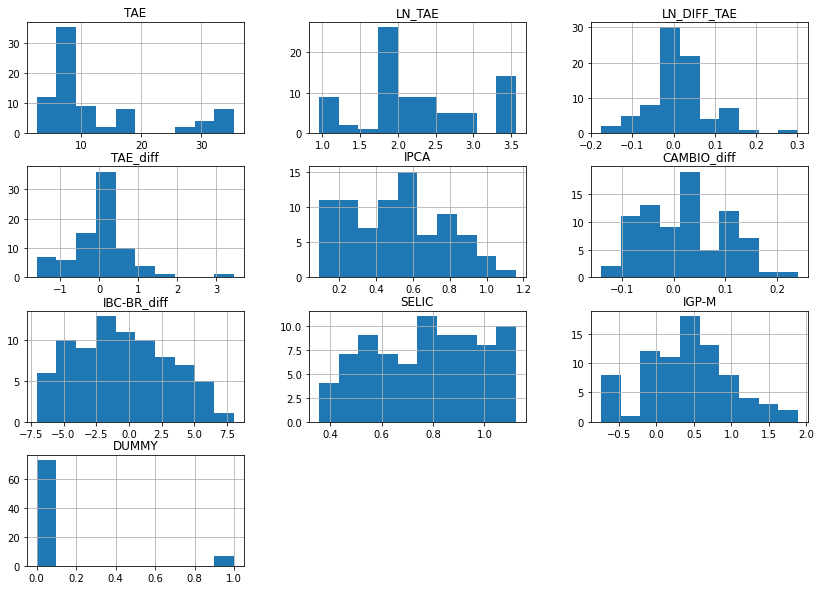

In [84]:
#hist de df
df_sem_outliers.hist(figsize=(14, 10))

In [100]:
import statsmodels.api as sm

# Define the independent variables
#X = df_sem_outliers[[ 'CAMBIO_diff', 'IGP-M','SELIC',  'DUMMY', 'IBC-BR_diff']]
X = df_sem_outliers[[ 'CAMBIO_diff',  'DUMMY', 'IBC-BR_diff']]
# Add a constant column to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df_sem_outliers['LN_DIFF_TAE']

# Fit the multiple regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            LN_DIFF_TAE   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     2.613
Date:                Tue, 11 Jun 2024   Prob (F-statistic):             0.0573
Time:                        10:39:20   Log-Likelihood:                 97.965
No. Observations:                  80   AIC:                            -187.9
Df Residuals:                      76   BIC:                            -178.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0147      0.009      1.681      

In [101]:
# Calculate VIF for each feature

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

       feature       VIF
0        const  1.155128
1  CAMBIO_diff  1.087526
2        DUMMY  1.093837
3  IBC-BR_diff  1.007222


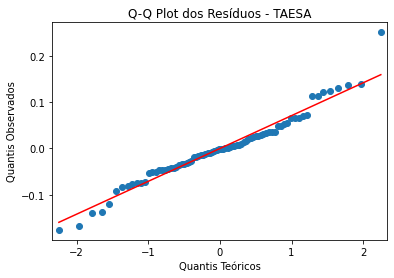

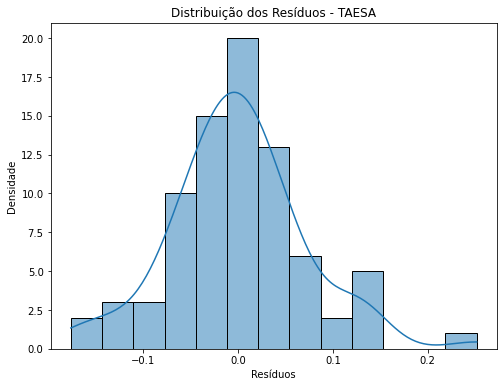

In [103]:
import statsmodels.api as sm# Get the residuals

from statsmodels.graphics.gofplots import qqplot
residuals = results.resid
#qq plot indica se os resíduos são normais quanto mais próximo da linha diagonal
qqplot(residuals, line='s') 
plt.title('Q-Q Plot dos Resíduos - TAESA')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis Observados')
plt.show()

#histograma para poder visualizar a normalidade melhor
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos - TAESA')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()

## Tratamento de outlier + defasagem pelo PACF

In [89]:
df_sem_outliers

,TAE,LN_TAE,LN_DIFF_TAE,TAE_diff,IPCA,CAMBIO_diff,IBC-BR_diff,SELIC,IGP-M,DUMMY
0,3.281391,1.188268,0.302208,0.855837,0.77,-0.07,-5.04,0.840161,0.45,0
1,3.281391,1.188268,0.000000,0.000000,0.47,0.02,3.34,0.987988,0.43,0
2,3.117224,1.136943,-0.051325,-0.164167,0.15,-0.02,-1.48,0.956276,-0.18,0
3,2.915920,1.070185,-0.066758,-0.201304,0.16,-0.03,3.44,0.967883,-0.12,0
4,3.281391,1.188268,0.118082,0.365471,0.37,0.04,2.32,1.074062,0.44,0
...,...,...,...,...,...,...,...,...,...,...
141,33.378375,3.507908,-0.043287,-1.476586,0.84,-0.03,4.93,0.918142,-0.06,0
146,33.929115,3.524273,-0.044548,-1.545660,0.12,-0.05,4.72,1.071983,-0.72,0
148,33.481598,3.510996,-0.004003,-0.134292,0.26,0.04,-6.44,0.972910,0.37,0
149,32.663823,3.486268,-0.024728,-0.817775,0.24,0.12,0.17,0.997572,0.50,0


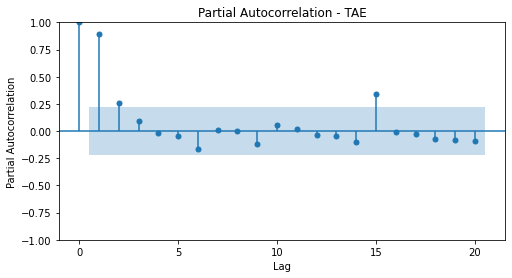

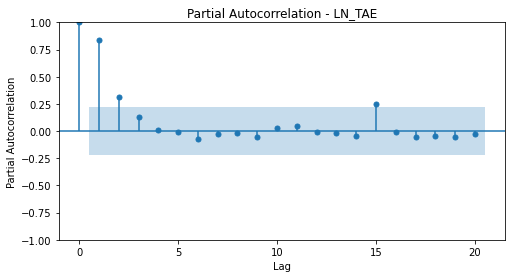

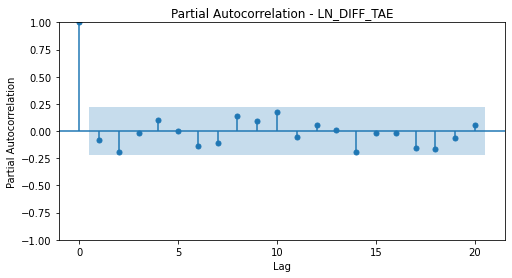

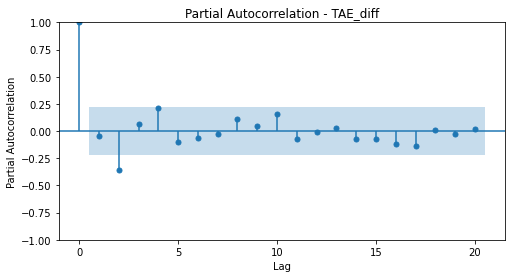

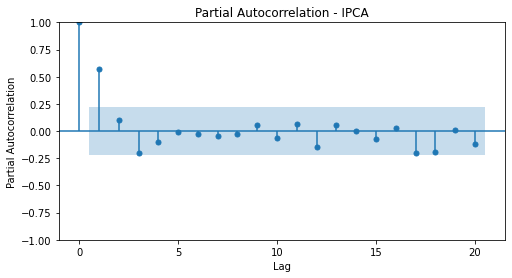

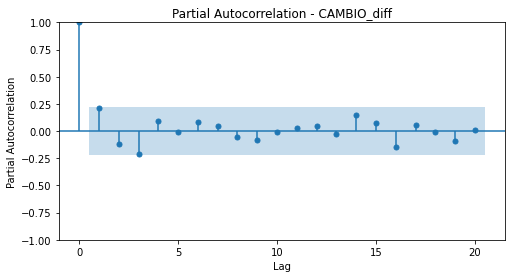

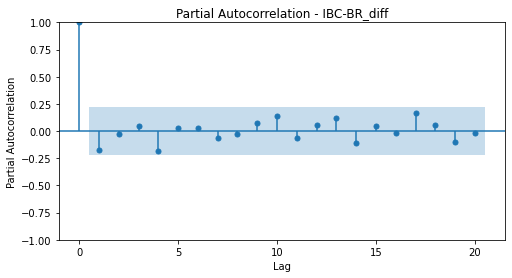

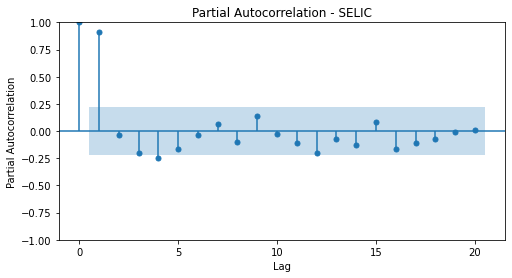

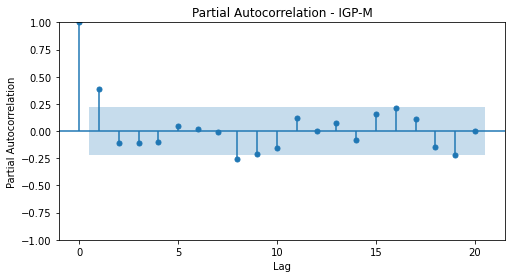

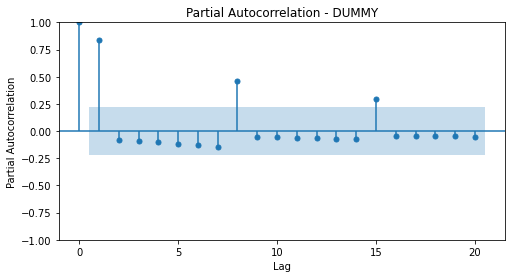

In [90]:
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt

# Iterate over each column in df_sem_outliers
for column in df_sem_outliers.columns:
    # Plot PACF for the current column
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_pacf(df_sem_outliers[column], ax=ax, lags=20)
    ax.set_title(f'Partial Autocorrelation - {column}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Partial Autocorrelation')
    plt.show()

IBCBR 2 defasagens

IPCA 2 defasagens

CDI 2

o resto 1 defasagem

In [93]:
TAE1LAG = df_sem_outliers['LN_DIFF_TAE'].shift(1)
IPCA2LAG = df_sem_outliers['IPCA'].shift(2)
CAMBIO1LAG = df_sem_outliers['CAMBIO_diff'].shift(1)
IBCBR2LAG = df_sem_outliers['IBC-BR_diff'].shift(2)
CDI2LAG = df_sem_outliers['SELIC'].shift(2)
IGPM2LAG = df_sem_outliers['IGP-M'].shift(2)

data = pd.DataFrame({'TAE1LAG': TAE1LAG,
                    'CDI2LAG': CDI2LAG,
                    'IBCBR2LAG':IBCBR2LAG,
                    'IPCA2LAG': IPCA2LAG,
                    'CAMBIO1LAG' : CAMBIO1LAG,
                    'IGPM2LAG': IGPM2LAG,
                    'DUMMY': df['DUMMY']
                    })
data = data.dropna()

In [99]:
y = data['TAE1LAG']
X = data[['CAMBIO1LAG','DUMMY',  'IPCA2LAG' ]] 
#X = data[['CAMBIO1LAG','DUMMY', 'IGPM2LAG' , 'IPCA2LAG','CDI2LAG', 'IBCBR2LAG' ]]
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                TAE1LAG   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.543
Date:                Mon, 10 Jun 2024   Prob (F-statistic):              0.211
Time:                        15:21:31   Log-Likelihood:                 101.64
No. Observations:                  78   AIC:                            -195.3
Df Residuals:                      74   BIC:                            -185.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0221      0.018      1.199      0.2